In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import sys
print (sys.version)

2.7.15 |Anaconda, Inc.| (default, Nov 13 2018, 17:07:45) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [100]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import importlib
import pandas as pd
from scipy.stats import bernoulli
from matplotlib import cm
from numpy import linalg as LA
from mpl_toolkits.mplot3d import Axes3D # This import has side effects required for the kwarg projection='3d' in the call to fig.add_subplot
import random
import pickle

import generative_lib

In [101]:
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [146]:
reload(generative_lib)

<module 'generative_lib' from 'generative_lib.py'>

In [103]:
from classifiers import AdversarialExample

In [104]:
def load_pkl(path, delta = 500.0):
    af = open(adversary_path, "rb")
    exs = pickle.load(af)
    af.close()

    # remove all adversary that is None
    exs = filter(lambda ex: ex is not None, exs)
    # remove all adversary whose norm is > delta
    exs = filter(lambda ex: ex.adv_diff_norm < delta, exs)
    # sort examples by increasing diff norm
    exs.sort(key = lambda ex: ex.adv_diff_norm)
    
    return exs

Model :  Logistic_LRL
x shape               : torch.Size([1, 784])
adversary shape       : torch.Size([1, 784])
True label            : 9
Make model think      : 4
||x - adversary||2    : 0.14367643
model probs. with x   : 
[0.   0.   0.   0.   0.19 0.01 0.   0.01 0.   0.79]
model probs. with adv : 
[0.   0.   0.   0.   0.52 0.01 0.   0.01 0.   0.45]



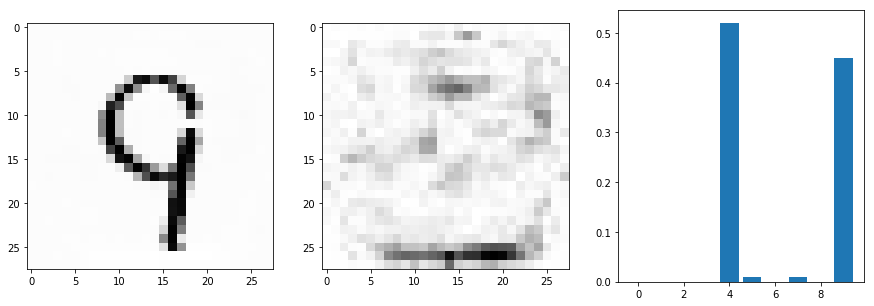

In [128]:
orig_adversary_path = 'adversary_dataset/CONFIDENCE_50/mnist_img_advex/Logistic_LRL_advex/advex.pkl'

exs = load_pkl(orig_adversary_path)

for ex in exs:
    print ex
    ex.show()
    break

In [119]:
image_width = 28

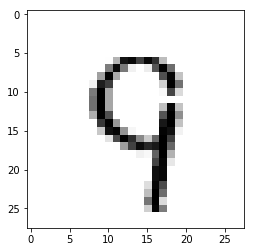

In [120]:
# Random img in the test set
test_img = ex.x
plt.imshow(test_img.reshape([image_width,image_width]),cmap='binary')

In [121]:
pathAE = 'trained_models/AE_MNIST.pt'
num_features = 784
num_hidden_1 = 32

AE = generative_lib.AE_1L(num_features,num_hidden_1)
AE.load_state_dict(torch.load(pathAE))
AE.eval()

AEgen = generative_lib.AEcopyGen(AE,num_features,num_hidden_1)

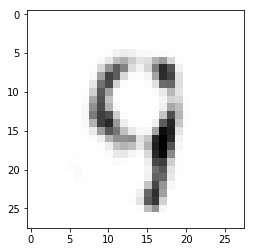

In [122]:
# Reconstruction using autoencoder
test_enc = AE.encoder(test_img.reshape(image_width*image_width))
test_dec = AE.decoder(test_enc).detach().numpy()

plt.imshow(test_dec.reshape([image_width,image_width]),cmap='binary')

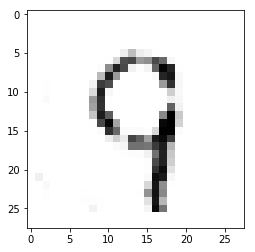

In [123]:
# reconstruction by projection
maxit = 500
gamma  = 0.5
x0    = test_enc*20-10
Gstar = test_img.reshape(image_width*image_width) #model.decoder(test_enc).detach()
rand_init = 5
sigma = 5

[l2_loss_var,xk2] = generative_lib.Full_Projection(AEgen, Gstar, maxit, gamma, rand_init, sigma, x0, generative_lib.L2_Project)

pctk2 = AEgen(xk2)
plt.imshow(pctk2.cpu().detach().numpy().reshape(28,28),  cmap='Greys')

# MNIST

## 50 %

In [141]:
adv_path = 'adversary_dataset/CONFIDENCE_50/mnist_img_advex/'
pkl_path = '/advex.pkl'

### AutoEncoder

In [142]:
pathAE = 'trained_models/AE_MNIST.pt'
num_features = 784
num_hidden_1 = 32

AE = generative_lib.AE_1L(num_features,num_hidden_1)
AE.load_state_dict(torch.load(pathAE))
AE.eval()

AEgen = generative_lib.AEcopyGen(AE,num_features,num_hidden_1)

In [143]:
AE_latent_L2  = [];
AE_latent     = [];

# reconstruction by projection
maxit = 500
gamma  = 0.5
x0    = torch.zeros([num_hidden_1])
rand_init = 1
sigma = 5

In [144]:
folders = ['Logistic_1L_advex', 'Logistic_2L_advex', 'Logistic_LRL_advex']

for folder in folders:
    # load adversary
    adversary_path = adv_path+folder+pkl_path
    exs = load_pkl(adversary_path)
    
    print(folder)
    
    for ex in exs:
        Gstar = ex.x.reshape(image_width*image_width)
        
        # latent via encoder
        latEnc = AE.encoder(Gstar)
        AE_latent.append(latEnc)
    
        # latent via projection
        Gstar = ex.x.reshape(image_width*image_width) #model.decoder(test_enc).detach()
        [_,latL2] = generative_lib.Full_Projection(AEgen, Gstar, maxit, gamma, rand_init, sigma, x0, generative_lib.L2_Project)
        AE_latent_L2.append(latL2)
    
    # save latents via Encoder
    pickle_f = open(adv_path+folder+'AE_latent.pkl', "w+")
    pickle.dump(AE_latent, pickle_f)
    pickle_f.close()
    
    # save latents via Projection
    pickle_f = open(adv_path+folder+'AE_latent_L2.pkl', "w+")
    pickle.dump(AE_latent_L2, pickle_f)
    pickle_f.close()

Logistic_1L_advex
Logistic_2L_advex
Logistic_LRL_advex


### Variational AE 

In [147]:
pathVAE = 'trained_models/VAE_MNIST.pt'
num_features = 784
num_hidden_1 = 150
num_latent   = 32

VAE = generative_lib.VAE(num_features,num_hidden_1,num_latent)
VAE.load_state_dict(torch.load(pathVAE))
VAE.eval()

VAEgen = generative_lib.VAEcopyGen(VAE,num_features,num_hidden_1,num_latent)

In [151]:
VAE_latent_L2  = [];
VAE_latent     = [];

# reconstruction by projection
maxit = 500
gamma  = 0.5
x0    = torch.zeros([num_latent])
rand_init = 1
sigma = 5

In [153]:
folders = ['Logistic_1L_advex', 'Logistic_2L_advex', 'Logistic_LRL_advex']

for folder in folders:
    # load adversary
    adversary_path = adv_path+folder+pkl_path
    exs = load_pkl(adversary_path)
    
    print(folder)

    for ex in exs:
        Gstar = ex.x.reshape([1,image_width*image_width])
        
        # latent via encoder
        [latEnc,z_mean,z_log_var] = VAE.encoder(Gstar)
        VAE_latent.append(latEnc)
    
        # latent via projection
        Gstar = ex.x.reshape(image_width*image_width) #model.decoder(test_enc).detach()
        [_,latL2] = generative_lib.Full_Projection(VAEgen, Gstar, maxit, gamma, rand_init, sigma, x0, generative_lib.L2_Project)
        VAE_latent_L2.append(latL2)
    
    # save latents via Encoder
    pickle_f = open(adv_path+folder+'VAE_latent.pkl', "w+")
    pickle.dump(VAE_latent, pickle_f)
    pickle_f.close()
    
    # save latents via Projection
    pickle_f = open(adv_path+folder+'VAE_latent_L2.pkl', "w+")
    pickle.dump(VAE_latent_L2, pickle_f)
    pickle_f.close()

Logistic_1L_advex
Logistic_2L_advex
Logistic_LRL_advex
